# Section 1: Relational Data Model Design & Implementation

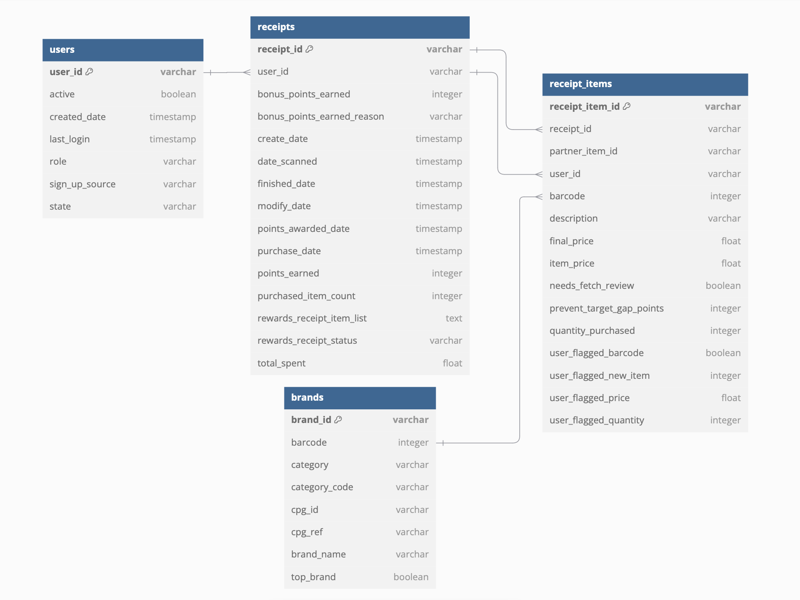

In [29]:
from IPython.display import display
from PIL import Image

img = Image.open("images/er_diagram.png")

display(img.resize((800, 600)))

## Preliminary Data Loading Functions

In [1]:
import json
import pandas as pd
from sqlalchemy import create_engine, text

# Create an in-memory SQLite engine
engine = create_engine('sqlite:///:memory:')

def create_staging_table(table_name):
    """
    Create a staging table with a single column (raw_data) for the given table name.
    """
    create_stmt = f"""
    create table {table_name} (
        raw_data TEXT
    );
    """
    with engine.connect() as conn:
        conn.execute(text(create_stmt))

def load_json_into_table(file_path, table_name):
    """
    Read a JSON file (one JSON object per line) and insert each line
    into the specified staging table.
    """
    # Read non-empty lines from the file
    with open(file_path, 'r') as f:
        lines = [line.strip() for line in f if line.strip()]
    
    with engine.connect() as conn:
        for line in lines:
            conn.execute(
                text(f"insert into {table_name} (raw_data) values (:raw_data)"),
                {"raw_data": line}
            )

def run_query(query):
    """
    Execute the provided SQL query and return the results as a pandas DataFrame.
    """
    return pd.read_sql(query, engine)

## Loading JSON Files into Environment

In [2]:
users_table = "staging_users"
create_staging_table(users_table)
load_json_into_table("datasets/users.json", users_table)


receipts_table = "staging_receipts"
create_staging_table(receipts_table)
load_json_into_table("datasets/receipts.json", receipts_table)


brands_table = "staging_brands"
create_staging_table(brands_table)
load_json_into_table("datasets/brands.json", brands_table)

## SQL to Clean JSON Files

In [3]:
# Process users.json

users_query = text("""
select
    json_extract(raw_data, '$._id.$oid') AS user_id,
    json_extract(raw_data, '$.active') AS active,
    datetime(json_extract(raw_data, '$.createdDate.$date') / 1000, 'unixepoch') AS created_date,
    datetime(json_extract(raw_data, '$.lastLogin.$date') / 1000, 'unixepoch') AS last_login,
    json_extract(raw_data, '$.role') AS role,
    json_extract(raw_data, '$.signUpSource') AS sign_up_source,
    json_extract(raw_data, '$.state') AS state
from staging_users;
""")

users = run_query(users_query)
users.to_sql('users', engine, if_exists='replace', index=False)

users.head()

,user_id,active,created_date,last_login,role,sign_up_source,state
0,5ff1e194b6a9d73a3a9f1052,1,2021-01-03 15:24:04,2021-01-03 15:25:37,consumer,Email,WI
1,5ff1e194b6a9d73a3a9f1052,1,2021-01-03 15:24:04,2021-01-03 15:25:37,consumer,Email,WI
2,5ff1e194b6a9d73a3a9f1052,1,2021-01-03 15:24:04,2021-01-03 15:25:37,consumer,Email,WI
3,5ff1e1eacfcf6c399c274ae6,1,2021-01-03 15:25:30,2021-01-03 15:25:30,consumer,Email,WI
4,5ff1e194b6a9d73a3a9f1052,1,2021-01-03 15:24:04,2021-01-03 15:25:37,consumer,Email,WI


In [4]:
# Process brands.json

brands_query = text("""
select
    json_extract(raw_data, '$._id.$oid') as brand_id,
    json_extract(raw_data, '$.barcode') as barcode,
    json_extract(raw_data, '$.category') as category,
    json_extract(raw_data, '$.categoryCode') as category_code,
    json_extract(raw_data, '$.cpg.$id.$oid') as cpg_id,
    json_extract(raw_data, '$.cpg.$ref') as cpg_ref,
    json_extract(raw_data, '$.name') as brand_name,
    json_extract(raw_data, '$.topBrand') as top_brand
from staging_brands;
""")

brands = run_query(brands_query)
brands.to_sql('brands', engine, if_exists='replace', index=False)

brands.head()

,brand_id,barcode,category,category_code,cpg_id,cpg_ref,brand_name,top_brand
0,601ac115be37ce2ead437551,511111019862,Baking,BAKING,601ac114be37ce2ead437550,Cogs,test brand @1612366101024,0.0
1,601c5460be37ce2ead43755f,511111519928,Beverages,BEVERAGES,5332f5fbe4b03c9a25efd0ba,Cogs,Starbucks,0.0
2,601ac142be37ce2ead43755d,511111819905,Baking,BAKING,601ac142be37ce2ead437559,Cogs,test brand @1612366146176,0.0
3,601ac142be37ce2ead43755a,511111519874,Baking,BAKING,601ac142be37ce2ead437559,Cogs,test brand @1612366146051,0.0
4,601ac142be37ce2ead43755e,511111319917,Candy & Sweets,CANDY_AND_SWEETS,5332fa12e4b03c9a25efd1e7,Cogs,test brand @1612366146827,0.0


In [5]:
# Process receipts.json

receipts_query = text("""
select
    json_extract(raw_data, '$._id.$oid') as receipt_id,
    json_extract(raw_data, '$.userId') as user_id,
    json_extract(raw_data, '$.bonusPointsEarned') as bonus_points_earned,
    json_extract(raw_data, '$.bonusPointsEarnedReason') as bonus_points_earned_reason,
    datetime(json_extract(raw_data, '$.createDate.$date') / 1000, 'unixepoch') as create_date,
    datetime(json_extract(raw_data, '$.dateScanned.$date') / 1000, 'unixepoch') as date_scanned,
    datetime(json_extract(raw_data, '$.finishedDate.$date') / 1000, 'unixepoch') as finished_date,
    datetime(json_extract(raw_data, '$.modifyDate.$date') / 1000, 'unixepoch') as modify_date,
    datetime(json_extract(raw_data, '$.pointsAwardedDate.$date') / 1000, 'unixepoch') as points_awarded_date,
    json_extract(raw_data, '$.pointsEarned') as points_earned,
    datetime(json_extract(raw_data, '$.purchaseDate.$date') / 1000, 'unixepoch') as purchase_date,
    json_extract(raw_data, '$.purchasedItemCount') as purchased_item_count,
    json_extract(raw_data, '$.rewardsReceiptItemList') as rewards_receipt_item_list,
    json_extract(raw_data, '$.rewardsReceiptStatus') as rewards_receipt_status,
    json_extract(raw_data, '$.totalSpent') as total_spent
from staging_receipts;
""")

receipts = run_query(receipts_query)
receipts.to_sql('receipts', engine, if_exists='replace', index=False)

receipts.head(10)

,receipt_id,user_id,bonus_points_earned,bonus_points_earned_reason,create_date,date_scanned,finished_date,modify_date,points_awarded_date,points_earned,purchase_date,purchased_item_count,rewards_receipt_item_list,rewards_receipt_status,total_spent
0,5ff1e1eb0a720f0523000575,5ff1e1eacfcf6c399c274ae6,500.0,"Receipt number 2 completed, bonus point schedu...",2021-01-03 15:25:31,2021-01-03 15:25:31,2021-01-03 15:25:31,2021-01-03 15:25:36,2021-01-03 15:25:31,500.0,2021-01-03 00:00:00,5.0,"[{""barcode"":""4011"",""description"":""ITEM NOT FOU...",FINISHED,26.00
1,5ff1e1bb0a720f052300056b,5ff1e194b6a9d73a3a9f1052,150.0,"Receipt number 5 completed, bonus point schedu...",2021-01-03 15:24:43,2021-01-03 15:24:43,2021-01-03 15:24:43,2021-01-03 15:24:48,2021-01-03 15:24:43,150.0,2021-01-02 15:24:43,2.0,"[{""barcode"":""4011"",""description"":""ITEM NOT FOU...",FINISHED,11.00
2,5ff1e1f10a720f052300057a,5ff1e1f1cfcf6c399c274b0b,5.0,All-receipts receipt bonus,2021-01-03 15:25:37,2021-01-03 15:25:37,None,2021-01-03 15:25:42,None,5,2021-01-03 00:00:00,1.0,"[{""needsFetchReview"":false,""partnerItemId"":""1""...",REJECTED,10.00
3,5ff1e1ee0a7214ada100056f,5ff1e1eacfcf6c399c274ae6,5.0,All-receipts receipt bonus,2021-01-03 15:25:34,2021-01-03 15:25:34,2021-01-03 15:25:34,2021-01-03 15:25:39,2021-01-03 15:25:34,5.0,2021-01-03 00:00:00,4.0,"[{""barcode"":""4011"",""description"":""ITEM NOT FOU...",FINISHED,28.00
4,5ff1e1d20a7214ada1000561,5ff1e194b6a9d73a3a9f1052,5.0,All-receipts receipt bonus,2021-01-03 15:25:06,2021-01-03 15:25:06,2021-01-03 15:25:11,2021-01-03 15:25:11,2021-01-03 15:25:06,5.0,2021-01-02 15:25:06,2.0,"[{""barcode"":""4011"",""description"":""ITEM NOT FOU...",FINISHED,1.00
5,5ff1e1e40a7214ada1000566,5ff1e1e4cfcf6c399c274ac3,750.0,"Receipt number 1 completed, bonus point schedu...",2021-01-03 15:25:24,2021-01-03 15:25:24,2021-01-03 15:25:25,2021-01-03 15:25:30,2021-01-03 15:25:25,750.0,2021-01-02 15:25:24,1.0,"[{""barcode"":""4011"",""description"":""ITEM NOT FOU...",FINISHED,3.25
6,5ff1e1cd0a720f052300056f,5ff1e194b6a9d73a3a9f1052,5.0,All-receipts receipt bonus,2021-01-03 15:25:01,2021-01-03 15:25:01,2021-01-03 15:25:02,2021-01-03 15:25:02,2021-01-03 15:25:02,5.0,2021-01-03 15:25:01,1.0,"[{""brandCode"":""MISSION"",""competitorRewardsGrou...",FINISHED,2.23
7,5ff1e1a40a720f0523000569,5ff1e194b6a9d73a3a9f1052,500.0,"Receipt number 2 completed, bonus point schedu...",2021-01-03 15:24:20,2021-01-03 15:24:20,2021-01-03 15:24:21,2021-01-03 15:24:21,2021-01-03 15:24:21,500.0,2020-12-27 00:00:00,1.0,"[{""barcode"":""046000832517"",""brandCode"":""BRAND""...",FINISHED,10.00
8,5ff1e1ed0a7214ada100056e,5ff1e1eacfcf6c399c274ae6,5.0,All-receipts receipt bonus,2021-01-03 15:25:33,2021-01-03 15:25:33,2021-01-03 15:25:34,2021-01-03 15:25:38,2021-01-03 15:25:34,5.0,2021-01-03 00:00:00,5.0,"[{""barcode"":""4011"",""description"":""ITEM NOT FOU...",FINISHED,20.00
9,5ff1e1eb0a7214ada100056b,5ff1e1eacfcf6c399c274ae6,250.0,"Receipt number 3 completed, bonus point schedu...",2021-01-03 15:25:31,2021-01-03 15:25:31,2021-01-03 15:25:31,2021-01-03 15:25:36,2021-01-03 15:25:31,250.0,2021-01-03 00:00:00,3.0,"[{""barcode"":""4011"",""description"":""ITEM NOT FOU...",FINISHED,20.00


In [6]:
# We use SQLite's json_each() to "explode" the JSON array.
receipt_items_query = text("""
with cleaned as (
  select
    pr.receipt_id,
    pr.user_id,
    json_extract(item.value, '$.barcode') as barcode,
    json_extract(item.value, '$.description') as description,
    json_extract(item.value, '$.finalPrice') as final_price,
    json_extract(item.value, '$.itemPrice') as item_price,
    json_extract(item.value, '$.needsFetchReview') as needs_fetch_review,
    json_extract(item.value, '$.partnerItemId') as partner_item_id,
    json_extract(item.value, '$.preventTargetGapPoints') as prevent_target_gap_points,
    json_extract(item.value, '$.quantityPurchased') as quantity_purchased,
    json_extract(item.value, '$.userFlaggedBarcode') as user_flagged_barcode,
    json_extract(item.value, '$.userFlaggedNewItem') as user_flagged_new_item,
    json_extract(item.value, '$.userFlaggedPrice') as user_flagged_price,
    json_extract(item.value, '$.userFlaggedQuantity') as user_flagged_quantity,
    (pr.receipt_id || coalesce(json_extract(item.value, '$.partnerItemId'), '')) as receipt_item_id
  from receipts as pr,
       json_each(pr.rewards_receipt_item_list) as item
)
select
  receipt_item_id,
  receipt_id,
  partner_item_id,
  user_id,
  barcode,
  description,
  final_price,
  item_price,
  needs_fetch_review,
  prevent_target_gap_points,
  quantity_purchased,
  user_flagged_barcode,
  user_flagged_new_item,
  user_flagged_price,
  user_flagged_quantity
from cleaned;
""")

receipt_items = run_query(receipt_items_query)
receipt_items.to_sql('receipt_items', engine, if_exists='replace', index=False)

receipt_items.head(10)

,receipt_item_id,receipt_id,partner_item_id,user_id,barcode,description,final_price,item_price,needs_fetch_review,prevent_target_gap_points,quantity_purchased,user_flagged_barcode,user_flagged_new_item,user_flagged_price,user_flagged_quantity
0,5ff1e1eb0a720f05230005751,5ff1e1eb0a720f0523000575,1,5ff1e1eacfcf6c399c274ae6,4011,ITEM NOT FOUND,26.00,26.00,0.0,1.0,5.0,4011,1.0,26.00,5.0
1,5ff1e1bb0a720f052300056b1,5ff1e1bb0a720f052300056b,1,5ff1e194b6a9d73a3a9f1052,4011,ITEM NOT FOUND,1,1,NaN,NaN,1.0,None,NaN,None,NaN
2,5ff1e1bb0a720f052300056b2,5ff1e1bb0a720f052300056b,2,5ff1e194b6a9d73a3a9f1052,028400642255,DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCE...,10.00,10.00,1.0,1.0,1.0,028400642255,1.0,10.00,1.0
3,5ff1e1f10a720f052300057a1,5ff1e1f10a720f052300057a,1,5ff1e1f1cfcf6c399c274b0b,None,None,None,None,0.0,1.0,NaN,4011,1.0,26.00,3.0
4,5ff1e1ee0a7214ada100056f1,5ff1e1ee0a7214ada100056f,1,5ff1e1eacfcf6c399c274ae6,4011,ITEM NOT FOUND,28.00,28.00,0.0,1.0,4.0,4011,1.0,28.00,4.0
5,5ff1e1d20a7214ada10005611,5ff1e1d20a7214ada1000561,1,5ff1e194b6a9d73a3a9f1052,4011,ITEM NOT FOUND,1,1,NaN,NaN,1.0,None,NaN,None,NaN
6,5ff1e1d20a7214ada10005612,5ff1e1d20a7214ada1000561,2,5ff1e194b6a9d73a3a9f1052,1234,None,2.56,2.56,1.0,1.0,3.0,1234,1.0,2.56,3.0
7,5ff1e1e40a7214ada10005661,5ff1e1e40a7214ada1000566,1,5ff1e1e4cfcf6c399c274ac3,4011,ITEM NOT FOUND,3.25,3.25,0.0,1.0,1.0,4011,NaN,None,NaN
8,5ff1e1cd0a720f052300056f1009,5ff1e1cd0a720f052300056f,1009,5ff1e194b6a9d73a3a9f1052,None,MSSN TORTLLA,2.23,2.23,NaN,NaN,1.0,None,NaN,None,NaN
9,5ff1e1a40a720f05230005690,5ff1e1a40a720f0523000569,0,5ff1e194b6a9d73a3a9f1052,046000832517,"Old El Paso Mild Chopped Green Chiles, 4.5 Oz",10.00,10.00,NaN,NaN,1.0,None,NaN,None,NaN


# Section 2: Business Question Answering

## Receipt Analysis

Here, we will attempt to answer the following questions:
* When considering average spend from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?
* When considering total number of items purchased from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?

To accomplish this, we will do a simple grouping of the receipts table by their rewards_receipt_status and calculate both the average spend and the number of items purchased.

In [7]:
rewards_status_query = """
select
    rewards_receipt_status,
    round(avg(total_spent),2) as avg_spend,
    sum(purchased_item_count) as items_purchased,
    count(*) as receipts
from receipts
group by 1
order by 4 desc
"""

rewards_status_stats = run_query(rewards_status_query)
rewards_status_stats.to_sql('rewards_status_stats', engine, if_exists='replace', index=False)

rewards_status_stats

,rewards_receipt_status,avg_spend,items_purchased,receipts
0,FINISHED,80.85,8184.0,518
1,SUBMITTED,NaN,NaN,434
2,REJECTED,23.33,173.0,71
3,PENDING,28.03,NaN,50
4,FLAGGED,180.45,1014.0,46


One thing we immediately notice with the output above is that the 'Accepted' value does not exist in the receipts table. Upon inspecting the possible values, 'Finished' seems to be the field with the same definition. We will bring this up in the Slack email later on, but for now we will assume 'Accepted' is the same as 'Finished' and use that to answer the questions below

### When considering average spend from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?

In [8]:
avg_spend_query = """
select
    rewards_receipt_status,
    avg_spend
from rewards_status_stats
where rewards_receipt_status in ('FINISHED', 'REJECTED')
"""

avg_spend_results = run_query(avg_spend_query)

avg_spend_results

,rewards_receipt_status,avg_spend
0,FINISHED,80.85
1,REJECTED,23.33


Answer: The former is greater. Receipts with rewards_receipt_status = 'FINISHED' have higher average spend compared to those where rewards_receipt_status = 'REJECTED'

### When considering total number of items purchased from receipts with 'rewardsReceiptStatus’ of ‘Accepted’ or ‘Rejected’, which is greater?


In [9]:
items_purchased_query = """
select
    rewards_receipt_status,
    items_purchased
from rewards_status_stats
where rewards_receipt_status in ('FINISHED', 'REJECTED')
"""

items_purchased_query = run_query(items_purchased_query)

items_purchased_query

,rewards_receipt_status,items_purchased
0,FINISHED,8184.0
1,REJECTED,173.0


Answer: The former is greater. There are more total items purchased among receipts with rewards_receipt_status = 'FINISHED' compared to those where rewards_receipt_status = 'REJECTED'

## Brand Analysis

Here, we will attempt to answer the following questions:
* Which brand has the most spend among users who were created within the past 6 months?
* Which brand has the most transactions among users who were created within the past 6 months?

The first thing we notice here is that the last recorded login of any user is 2021-03-05 and there are no records of anything after that date. This suggests that the 'past 6 months' subset of users should be looked at relative to that date instead of today.

To make the analysis below meaningful, 'today' will be set to 2021-03-05. 

To accomplish this, we will first inner join the receipt_items table with the users table on the user_id key and also add another conditional requiring the user to have been created at least 6 months before 'today'. With both the barcode and spend recorded, we can attch that information to the brand table, where we can use the barcode to obtain the brand name before aggregating and obtaining the relevant metrics.

In [10]:
brand_performance_query = """
with eligible_purchases as (
    select
        coalesce(ri.barcode, ri.user_flagged_barcode) as barcode,
        ri.final_price as spend
    from receipt_items ri
    inner join users u
    on ri.user_id = u.user_id
    and created_date > date((select max(last_login) from users), '-6 months')
)

select
    b.brand_name as brand,
    sum(e.spend) as total_spend,
    count(*) as transactions
from brands b
left join eligible_purchases e
on b.barcode = e.barcode
group by 1
order by 2 desc
"""

brand_performance = run_query(brand_performance_query)
brand_performance.to_sql('brand_performance', engine, if_exists='replace', index=False)
brand_performance.head()

,brand,total_spend,transactions
0,Cracker Barrel Cheese,253.26,4
1,Swanson,156.24,28
2,Tostitos,150.36,43
3,Cheetos,22.00,1
4,V8,13.49,2


### Which brand has the most spend among users who were created within the past 6 months?

In [11]:
brand_performance_spend = """
select
    brand,
    total_spend
from brand_performance
order by 2 desc
"""

brand_performance_spend = run_query(brand_performance_spend)

brand_performance_spend.head(5)

,brand,total_spend
0,Cracker Barrel Cheese,253.26
1,Swanson,156.24
2,Tostitos,150.36
3,Cheetos,22.00
4,V8,13.49


Answer: Cracker Barrel Cheese is the brand with the most speend among users created within the past 6 months.

### Which brand has the most transactions among users who were created within the past 6 months?

In [12]:
brand_performance_tx = """
select
    brand,
    transactions
from brand_performance
order by 2 desc
"""

brand_performance_tx = run_query(brand_performance_tx)

brand_performance_tx.head(5)

,brand,transactions
0,Tostitos,43
1,Swanson,28
2,Cracker Barrel Cheese,4
3,Kettle Brand,3
4,Pepperidge Farm,3


Answer: Tostitos is the brand with the most transactions among users created within the past 6 months. 

# Section 3: Data Quality Investigation